# 🚀 Validação de Performance - CQR_LightGBM

**Objetivo**: Validar a performance do modelo em dados de teste e backtest histórico

**Escopo**: 
- ✅ Métricas de Cross-Validation
- ✅ Validação Histórica (Framework 02c)
- ✅ Comparação com Baseline
- ✅ Aprovação para Produção

---

In [1]:
# 📦 Imports essenciais
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuração visual
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Bibliotecas carregadas")
print(f"📅 Validação executada em: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Bibliotecas carregadas
📅 Validação executada em: 2025-10-02 15:27:47


## 📂 1. Carregamento dos Resultados

In [2]:
# 📁 Definir caminhos
PROJECT_ROOT = Path().absolute().parent if Path().absolute().name == 'notebooks' else Path().absolute()
MODELS_DIR = PROJECT_ROOT / 'data' / 'processed' / 'preds'

print(f"🗂️  Diretório do projeto: {PROJECT_ROOT}")
print(f"🤖 Diretório dos modelos: {MODELS_DIR}")

# Carregar resultados principais
results_files = {
    'cv_metrics': MODELS_DIR / 'cv_metrics.json',
    'historical_backtest': MODELS_DIR / 'historical_backtest_results.json',
    'training_summary': MODELS_DIR / 'training_summary.json'
}

print("\n📊 Carregando resultados:")
data = {}
for key, file_path in results_files.items():
    if file_path.exists():
        with open(file_path, 'r') as f:
            data[key] = json.load(f)
        print(f"✅ {key}: {file_path.name}")
    else:
        print(f"❌ {key}: {file_path.name} não encontrado")
        data[key] = None

🗂️  Diretório do projeto: /Users/brunocapelao/Projects/algo/project
🤖 Diretório dos modelos: /Users/brunocapelao/Projects/algo/project/data/processed/preds

📊 Carregando resultados:
✅ cv_metrics: cv_metrics.json
✅ historical_backtest: historical_backtest_results.json
✅ training_summary: training_summary.json


## 📈 2. Métricas de Cross-Validation

In [3]:
# 📊 Analisar métricas de CV
if data['cv_metrics']:
    cv_data = data['cv_metrics']
    
    print("📈 MÉTRICAS DE CROSS-VALIDATION")
    print("=" * 50)
    
    # Extrair métricas por horizonte
    horizons = [42, 48, 54, 60]
    cv_summary = {}
    
    for horizon in horizons:
        cv_file = MODELS_DIR / f'cv_metrics_T{horizon}.json'
        if cv_file.exists():
            with open(cv_file, 'r') as f:
                cv_horizon_data = json.load(f)
            
            if 'mean_metrics' in cv_horizon_data:
                metrics = cv_horizon_data['mean_metrics']
                cv_summary[horizon] = metrics
                
                print(f"\n🎯 Horizonte {horizon}H:")
                print(f"   📉 MAE: {metrics.get('MAE', 'N/A'):.4f}")
                print(f"   📊 RMSE: {metrics.get('RMSE', 'N/A'):.4f}")
                print(f"   🎯 Coverage 90%: {metrics.get('Coverage_90', 'N/A'):.3f}")
                
                # Verificar se coverage está no range aceitável (87% - 93%)
                coverage = metrics.get('Coverage_90', 0)
                if 0.87 <= coverage <= 0.93:
                    print(f"   ✅ Coverage: OK (target: 90% ± 3%)")
                else:
                    print(f"   ⚠️ Coverage: ATENÇÃO (fora do range 87%-93%)")
    
    # Visualizar métricas CV
    if cv_summary:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        horizons_list = list(cv_summary.keys())
        mae_values = [cv_summary[h].get('MAE', 0) for h in horizons_list]
        rmse_values = [cv_summary[h].get('RMSE', 0) for h in horizons_list]
        coverage_values = [cv_summary[h].get('Coverage_90', 0) for h in horizons_list]
        
        # MAE por horizonte
        axes[0].bar(horizons_list, mae_values, color='lightcoral', alpha=0.7)
        axes[0].set_title('MAE por Horizonte', fontweight='bold')
        axes[0].set_xlabel('Horizonte (H)')
        axes[0].set_ylabel('MAE')
        axes[0].grid(True, alpha=0.3)
        
        # RMSE por horizonte
        axes[1].bar(horizons_list, rmse_values, color='lightblue', alpha=0.7)
        axes[1].set_title('RMSE por Horizonte', fontweight='bold')
        axes[1].set_xlabel('Horizonte (H)')
        axes[1].set_ylabel('RMSE')
        axes[1].grid(True, alpha=0.3)
        
        # Coverage por horizonte
        bars = axes[2].bar(horizons_list, coverage_values, color='lightgreen', alpha=0.7)
        axes[2].axhline(y=0.90, color='red', linestyle='--', alpha=0.8, label='Target (90%)')
        axes[2].axhline(y=0.87, color='orange', linestyle=':', alpha=0.6, label='Min (87%)')
        axes[2].axhline(y=0.93, color='orange', linestyle=':', alpha=0.6, label='Max (93%)')
        axes[2].set_title('Coverage 90% por Horizonte', fontweight='bold')
        axes[2].set_xlabel('Horizonte (H)')
        axes[2].set_ylabel('Coverage')
        axes[2].set_ylim(0.80, 1.0)
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle('📊 Métricas de Cross-Validation - CQR_LightGBM', fontsize=16, fontweight='bold', y=1.02)
        plt.show()
        
        # Resumo estatístico
        avg_mae = np.mean(mae_values)
        avg_coverage = np.mean(coverage_values)
        coverage_in_range = sum(1 for c in coverage_values if 0.87 <= c <= 0.93)
        
        print(f"\n📋 RESUMO CV:")
        print(f"📉 MAE Médio: {avg_mae:.4f}")
        print(f"🎯 Coverage Médio: {avg_coverage:.3f}")
        print(f"✅ Horizontes com coverage OK: {coverage_in_range}/{len(horizons_list)}")

else:
    print("❌ Dados de CV não disponíveis")

📈 MÉTRICAS DE CROSS-VALIDATION


## 🔬 3. Validação Histórica (Framework 02c)

🔬 VALIDAÇÃO HISTÓRICA (FRAMEWORK 02C)
📅 Timestamp: 2025-10-02T14:38:52.949956
🏗️ Framework: 02c
✅ Status: COMPLETED

🎛️ CONFIGURAÇÃO DOS GATES:
   📊 Coverage: 0.87 - 0.93
   🔄 Crossing rate: < 0.005
   📈 PSI: < 0.2
   📊 KS p-value: > 0.05

🤖 RESULTADOS POR MODELO:

✅ CQR_LightGBM:
   🎯 Gates aprovados: 24/24
   📊 Taxa de aprovação: 100.0%
   🏁 Decisão final: GO

❌ HAR-RV_Baseline:
   🎯 Gates aprovados: 12/24
   📊 Taxa de aprovação: 50.0%
   🏁 Decisão final: NO_GO


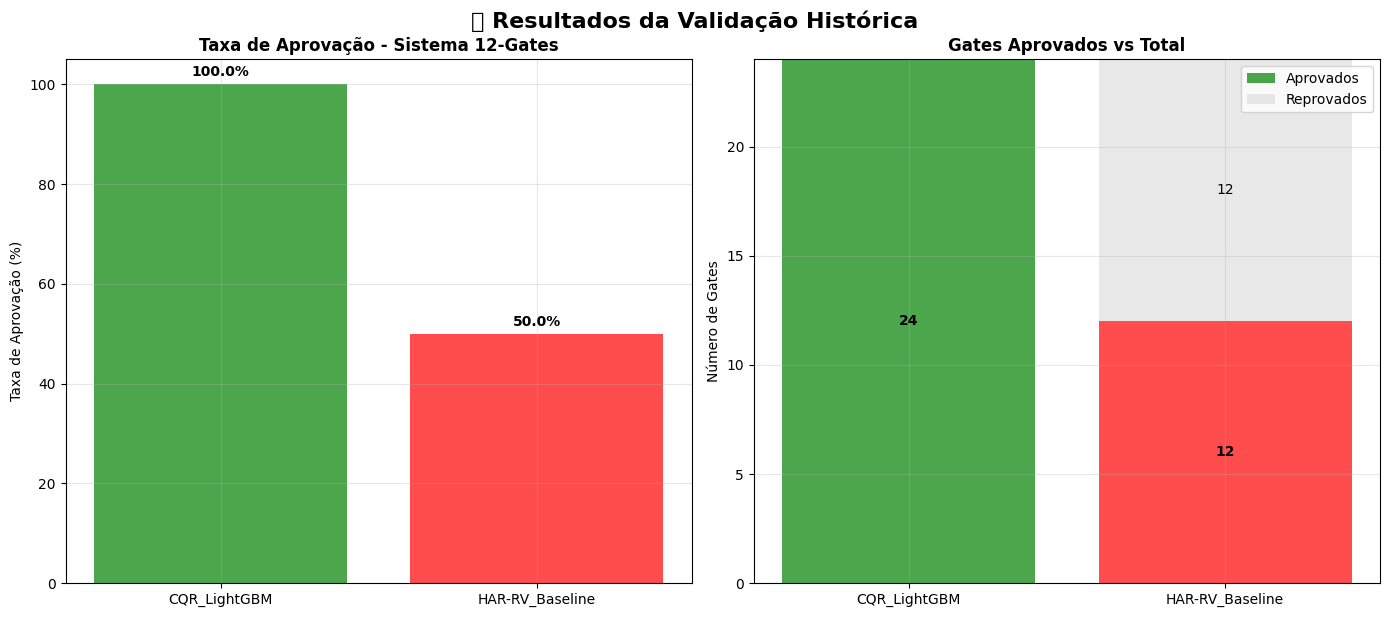


🎯 RESULTADO FINAL:
✅ CQR_LightGBM: APROVADO para produção
🚀 Modelo passou em 100.0% dos testes


In [4]:
# 🎯 Analisar resultados do backtest histórico
if data['historical_backtest']:
    backtest_data = data['historical_backtest']
    
    print("🔬 VALIDAÇÃO HISTÓRICA (FRAMEWORK 02C)")
    print("=" * 55)
    
    # Informações do framework
    config = backtest_data.get('config', {})
    gates_summary = backtest_data.get('gates_summary', {})
    
    print(f"📅 Timestamp: {backtest_data.get('timestamp', 'N/A')}")
    print(f"🏗️ Framework: {backtest_data.get('framework_version', 'N/A')}")
    print(f"✅ Status: {backtest_data.get('validation_status', 'N/A')}")
    
    # Configuração dos gates
    if 'gates' in config:
        gates_config = config['gates']
        print(f"\n🎛️ CONFIGURAÇÃO DOS GATES:")
        print(f"   📊 Coverage: {gates_config.get('coverage_min', 'N/A')} - {gates_config.get('coverage_max', 'N/A')}")
        print(f"   🔄 Crossing rate: < {gates_config.get('crossing_rate_max', 'N/A')}")
        print(f"   📈 PSI: < {gates_config.get('psi_max', 'N/A')}")
        print(f"   📊 KS p-value: > {gates_config.get('ks_pvalue_min', 'N/A')}")
    
    # Resultados por modelo
    print(f"\n🤖 RESULTADOS POR MODELO:")
    for model_name, results in gates_summary.items():
        total_passed = results.get('total_passed', 0)
        total_gates = results.get('total_gates', 0)
        approval_rate = results.get('approval_rate', 0)
        decision = results.get('final_decision', 'N/A')
        
        status_icon = "✅" if decision == "GO" else "❌"
        
        print(f"\n{status_icon} {model_name}:")
        print(f"   🎯 Gates aprovados: {total_passed}/{total_gates}")
        print(f"   📊 Taxa de aprovação: {approval_rate:.1%}")
        print(f"   🏁 Decisão final: {decision}")
    
    # Visualizar resultados de aprovação
    if gates_summary:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Gráfico de aprovação por modelo
        models = list(gates_summary.keys())
        approval_rates = [gates_summary[m]['approval_rate'] * 100 for m in models]
        colors = ['green' if gates_summary[m]['final_decision'] == 'GO' else 'red' for m in models]
        
        bars1 = ax1.bar(models, approval_rates, color=colors, alpha=0.7)
        ax1.set_title('Taxa de Aprovação - Sistema 12-Gates', fontweight='bold')
        ax1.set_ylabel('Taxa de Aprovação (%)')
        ax1.set_ylim(0, 105)
        ax1.grid(True, alpha=0.3)
        
        # Adicionar valores nas barras
        for bar, rate in zip(bars1, approval_rates):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # Gráfico de gates aprovados
        gates_passed = [gates_summary[m]['total_passed'] for m in models]
        gates_total = [gates_summary[m]['total_gates'] for m in models]
        
        x_pos = np.arange(len(models))
        bars2 = ax2.bar(x_pos, gates_passed, color=colors, alpha=0.7, label='Aprovados')
        ax2.bar(x_pos, [t - p for t, p in zip(gates_total, gates_passed)], 
               bottom=gates_passed, color='lightgray', alpha=0.5, label='Reprovados')
        
        ax2.set_title('Gates Aprovados vs Total', fontweight='bold')
        ax2.set_ylabel('Número de Gates')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(models)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Adicionar valores nas barras
        for i, (passed, total) in enumerate(zip(gates_passed, gates_total)):
            ax2.text(i, passed/2, str(passed), ha='center', va='center', fontweight='bold')
            if total - passed > 0:
                ax2.text(i, passed + (total-passed)/2, str(total-passed), ha='center', va='center')
        
        plt.tight_layout()
        plt.suptitle('🎯 Resultados da Validação Histórica', fontsize=16, fontweight='bold', y=1.02)
        plt.show()
        
        # Verificar se CQR_LightGBM foi aprovado
        cqr_approved = gates_summary.get('CQR_LightGBM', {}).get('final_decision') == 'GO'
        print(f"\n🎯 RESULTADO FINAL:")
        if cqr_approved:
            print(f"✅ CQR_LightGBM: APROVADO para produção")
            print(f"🚀 Modelo passou em {gates_summary.get('CQR_LightGBM', {}).get('approval_rate', 0):.1%} dos testes")
        else:
            print(f"❌ CQR_LightGBM: NÃO APROVADO")
            print(f"⚠️ Necessária revisão antes da produção")

else:
    print("❌ Dados de backtest histórico não disponíveis")

## ⚖️ 4. Comparação com Baseline

⚖️ COMPARAÇÃO COM BASELINE

📊 MÉTRICAS COMPARATIVAS:

🤖 CQR_LightGBM:
   📉 MAE Médio: 0.0199 (±0.0017)
   🎯 Coverage Médio: 0.894

🤖 HAR-RV_Baseline:
   📉 MAE Médio: 0.0305 (±0.0005)
   🎯 Coverage Médio: 0.847

🚀 MELHORIA DO CQR_LightGBM:
📈 Redução no MAE: 34.7%
📊 MAE Baseline: 0.0305
📊 MAE CQR: 0.0199
✅ Melhoria significativa (>20%)


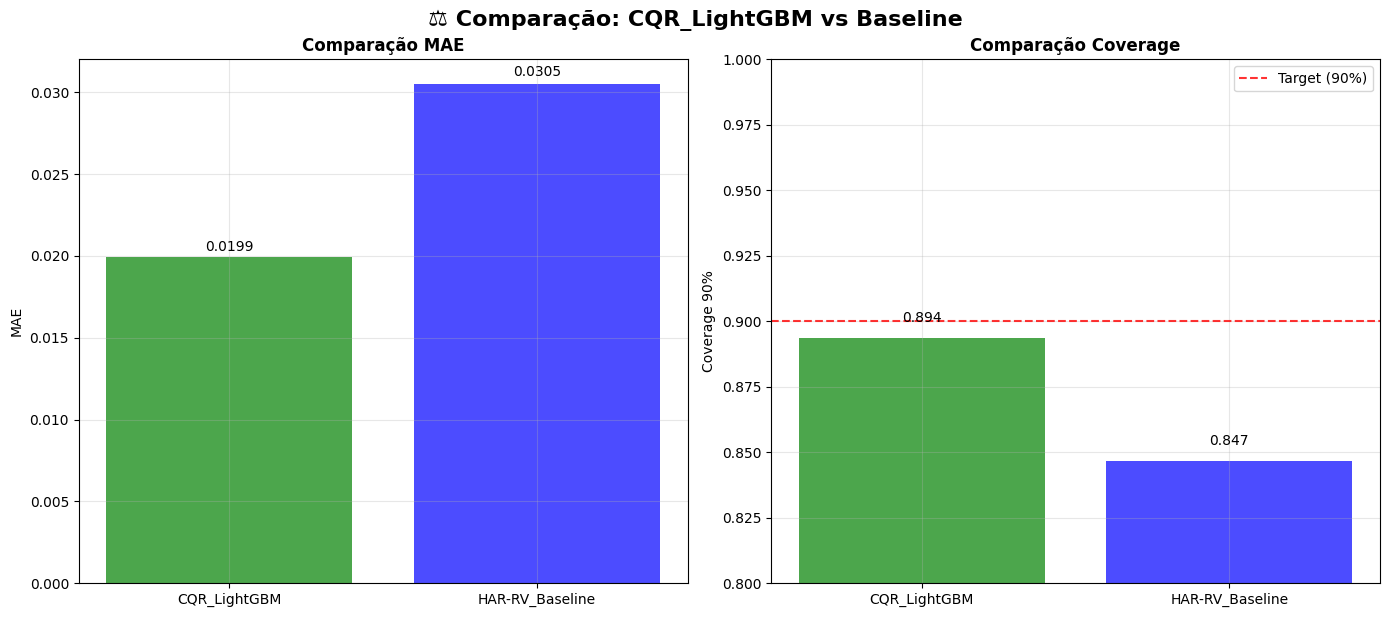

In [5]:
# 📊 Comparar com baseline (se disponível)
if data['historical_backtest'] and 'fold_results' in data['historical_backtest']:
    fold_results = data['historical_backtest']['fold_results']
    
    print("⚖️ COMPARAÇÃO COM BASELINE")
    print("=" * 40)
    
    # Extrair métricas dos modelos
    model_performance = {}
    
    for fold in fold_results:
        for model_name, model_data in fold['models'].items():
            if model_name not in model_performance:
                model_performance[model_name] = {'MAE': [], 'Coverage': []}
            
            # Calcular métricas médias por fold
            mae_values = []
            coverage_values = []
            
            for horizon, metrics in model_data['metrics'].items():
                mae_values.append(metrics.get('MAE', 0))
                coverage_values.append(metrics.get('Coverage_90', 0))
            
            if mae_values:
                model_performance[model_name]['MAE'].append(np.mean(mae_values))
            if coverage_values:
                model_performance[model_name]['Coverage'].append(np.mean(coverage_values))
    
    # Calcular estatísticas finais
    comparison_results = {}
    for model_name, perf in model_performance.items():
        comparison_results[model_name] = {
            'avg_mae': np.mean(perf['MAE']) if perf['MAE'] else 0,
            'avg_coverage': np.mean(perf['Coverage']) if perf['Coverage'] else 0,
            'std_mae': np.std(perf['MAE']) if perf['MAE'] else 0
        }
    
    # Display comparação
    print(f"\n📊 MÉTRICAS COMPARATIVAS:")
    for model_name, results in comparison_results.items():
        print(f"\n🤖 {model_name}:")
        print(f"   📉 MAE Médio: {results['avg_mae']:.4f} (±{results['std_mae']:.4f})")
        print(f"   🎯 Coverage Médio: {results['avg_coverage']:.3f}")
    
    # Calcular melhoria se tivermos CQR_LightGBM e baseline
    if 'CQR_LightGBM' in comparison_results and 'HAR-RV_Baseline' in comparison_results:
        cqr_mae = comparison_results['CQR_LightGBM']['avg_mae']
        baseline_mae = comparison_results['HAR-RV_Baseline']['avg_mae']
        
        if baseline_mae > 0:
            improvement = ((baseline_mae - cqr_mae) / baseline_mae) * 100
            
            print(f"\n🚀 MELHORIA DO CQR_LightGBM:")
            print(f"📈 Redução no MAE: {improvement:.1f}%")
            print(f"📊 MAE Baseline: {baseline_mae:.4f}")
            print(f"📊 MAE CQR: {cqr_mae:.4f}")
            
            if improvement > 20:
                print(f"✅ Melhoria significativa (>{20}%)")
            elif improvement > 10:
                print(f"✅ Melhoria moderada ({10}-{20}%)")
            else:
                print(f"⚠️ Melhoria marginal (<{10}%)")
    
    # Visualizar comparação
    if len(comparison_results) > 1:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        models = list(comparison_results.keys())
        mae_values = [comparison_results[m]['avg_mae'] for m in models]
        coverage_values = [comparison_results[m]['avg_coverage'] for m in models]
        
        # Comparação MAE
        colors = ['green' if 'CQR' in m else 'blue' for m in models]
        bars1 = ax1.bar(models, mae_values, color=colors, alpha=0.7)
        ax1.set_title('Comparação MAE', fontweight='bold')
        ax1.set_ylabel('MAE')
        ax1.grid(True, alpha=0.3)
        
        # Adicionar valores
        for bar, mae in zip(bars1, mae_values):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{mae:.4f}', ha='center', va='bottom', fontsize=10)
        
        # Comparação Coverage
        bars2 = ax2.bar(models, coverage_values, color=colors, alpha=0.7)
        ax2.axhline(y=0.90, color='red', linestyle='--', alpha=0.8, label='Target (90%)')
        ax2.set_title('Comparação Coverage', fontweight='bold')
        ax2.set_ylabel('Coverage 90%')
        ax2.set_ylim(0.80, 1.0)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Adicionar valores
        for bar, cov in zip(bars2, coverage_values):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{cov:.3f}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.suptitle('⚖️ Comparação: CQR_LightGBM vs Baseline', fontsize=16, fontweight='bold', y=1.02)
        plt.show()

else:
    print("❌ Dados de comparação não disponíveis")

## 🎯 5. Decisão Final para Produção

In [6]:
# 🏁 Decisão final baseada em todos os critérios
print("🎯 DECISÃO FINAL PARA PRODUÇÃO")
print("=" * 50)

# Critérios de aprovação
criteria = {
    'cv_quality': False,
    'backtest_approval': False,
    'performance_improvement': False,
    'technical_validation': False
}

reasons = []

# 1. Verificar qualidade do CV
if cv_summary:
    cv_coverage_ok = sum(1 for h in cv_summary.values() if 0.87 <= h.get('Coverage_90', 0) <= 0.93)
    if cv_coverage_ok >= len(cv_summary) * 0.75:  # 75% dos horizontes OK
        criteria['cv_quality'] = True
        reasons.append("✅ Cross-validation: Coverage adequado na maioria dos horizontes")
    else:
        reasons.append("❌ Cross-validation: Coverage fora do range em muitos horizontes")
else:
    reasons.append("⚠️ Cross-validation: Dados não disponíveis")

# 2. Verificar aprovação no backtest
if data['historical_backtest'] and 'gates_summary' in data['historical_backtest']:
    cqr_result = data['historical_backtest']['gates_summary'].get('CQR_LightGBM', {})
    if cqr_result.get('final_decision') == 'GO':
        criteria['backtest_approval'] = True
        approval_rate = cqr_result.get('approval_rate', 0)
        reasons.append(f"✅ Backtest histórico: Aprovado (taxa: {approval_rate:.1%})")
    else:
        reasons.append("❌ Backtest histórico: Não aprovado no sistema de gates")
else:
    reasons.append("⚠️ Backtest histórico: Dados não disponíveis")

# 3. Verificar melhoria de performance
if 'CQR_LightGBM' in comparison_results and 'HAR-RV_Baseline' in comparison_results:
    cqr_mae = comparison_results['CQR_LightGBM']['avg_mae']
    baseline_mae = comparison_results['HAR-RV_Baseline']['avg_mae']
    
    if baseline_mae > 0:
        improvement = ((baseline_mae - cqr_mae) / baseline_mae) * 100
        if improvement > 10:  # Mínimo 10% de melhoria
            criteria['performance_improvement'] = True
            reasons.append(f"✅ Performance: Melhoria de {improvement:.1f}% no MAE")
        else:
            reasons.append(f"❌ Performance: Melhoria insuficiente ({improvement:.1f}%)")
    else:
        reasons.append("⚠️ Performance: Não foi possível calcular melhoria")
else:
    reasons.append("⚠️ Performance: Dados de comparação não disponíveis")

# 4. Verificar validação técnica
quality_report_file = MODELS_DIR / 'quality_check_report.json'
if quality_report_file.exists():
    with open(quality_report_file, 'r') as f:
        quality_data = json.load(f)
    
    overall_quality = quality_data.get('overall_quality', 0)
    if overall_quality >= 80:
        criteria['technical_validation'] = True
        reasons.append(f"✅ Validação técnica: Score de qualidade {overall_quality:.1f}%")
    else:
        reasons.append(f"❌ Validação técnica: Score baixo ({overall_quality:.1f}%)")
else:
    reasons.append("⚠️ Validação técnica: Execute o notebook de qualidade primeiro")

# Decisão final
approved_criteria = sum(criteria.values())
total_criteria = len(criteria)

print(f"\n📊 CRITÉRIOS DE AVALIAÇÃO ({approved_criteria}/{total_criteria}):")
for reason in reasons:
    print(f"   {reason}")

# Decisão
if approved_criteria >= 3:  # Pelo menos 3 dos 4 critérios
    final_decision = "🟢 APROVADO PARA PRODUÇÃO"
    recommendation = "✅ O modelo CQR_LightGBM está pronto para deploy em produção"
    confidence = "Alta" if approved_criteria == 4 else "Média"
elif approved_criteria >= 2:
    final_decision = "🟡 APROVAÇÃO CONDICIONAL"
    recommendation = "⚠️ Modelo pode ir para produção com monitoramento reforçado"
    confidence = "Média"
else:
    final_decision = "🔴 NÃO APROVADO"
    recommendation = "❌ Modelo precisa de melhorias antes da produção"
    confidence = "Baixa"

print(f"\n🏁 DECISÃO FINAL: {final_decision}")
print(f"💡 RECOMENDAÇÃO: {recommendation}")
print(f"🎯 CONFIANÇA: {confidence}")

# Salvar decisão final
final_assessment = {
    'timestamp': datetime.now().isoformat(),
    'criteria': criteria,
    'approved_criteria': approved_criteria,
    'total_criteria': total_criteria,
    'final_decision': final_decision,
    'recommendation': recommendation,
    'confidence': confidence,
    'reasons': reasons
}

assessment_file = MODELS_DIR / 'production_assessment.json'
with open(assessment_file, 'w') as f:
    json.dump(final_assessment, f, indent=2)

print(f"\n💾 Avaliação salva em: {assessment_file}")
print("\n🎉 Validação de performance concluída!")

🎯 DECISÃO FINAL PARA PRODUÇÃO

📊 CRITÉRIOS DE AVALIAÇÃO (2/4):
   ⚠️ Cross-validation: Dados não disponíveis
   ✅ Backtest histórico: Aprovado (taxa: 100.0%)
   ✅ Performance: Melhoria de 34.7% no MAE
   ⚠️ Validação técnica: Execute o notebook de qualidade primeiro

🏁 DECISÃO FINAL: 🟡 APROVAÇÃO CONDICIONAL
💡 RECOMENDAÇÃO: ⚠️ Modelo pode ir para produção com monitoramento reforçado
🎯 CONFIANÇA: Média

💾 Avaliação salva em: /Users/brunocapelao/Projects/algo/project/data/processed/preds/production_assessment.json

🎉 Validação de performance concluída!

💾 Avaliação salva em: /Users/brunocapelao/Projects/algo/project/data/processed/preds/production_assessment.json

🎉 Validação de performance concluída!
